In [136]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

from torchmetrics import Accuracy

from pathlib import Path
from PIL import Image
import random

plt.style.use("dark_background")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [138]:
dataset1_dir = Path("data1")

full_dataset = ImageFolder(dataset1_dir)
print(full_dataset.classes)
print(len(full_dataset))

['anastasia', 'takao']
100


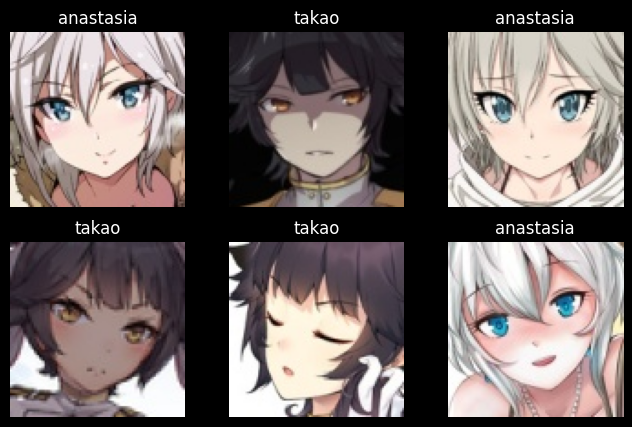

In [140]:
n_samples = 6

fig, axes = plt.subplots(nrows=2, ncols=n_samples//2, figsize=(8, 5))

for ax, (img, label) in zip(axes.flatten(), random.choices(full_dataset, k=n_samples)):
    ax.imshow(img)
    ax.set_title(full_dataset.classes[label])
    ax.axis("off")

In [141]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img.to(device), torch.tensor(label).to(device)

In [142]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [143]:
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

train_dataset = MyDataset(train_subset, transform=train_transform)
val_dataset = MyDataset(val_subset, transform=val_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 70
Validation samples: 30


In [154]:
class AnimeClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 16, kernel_size=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(16 * 14 * 14, num_classes),
        )
    
    def forward(self, X):
        return self.model(X)
    
    def predict(self, X):
        with torch.no_grad():
            return self.forward(X)


anime_classifier = AnimeClassifier(3, len(full_dataset.classes)).to(device)


Epoch 1/20: train_loss = 0.7001, val_loss = 0.6796
Epoch 2/20: train_loss = 0.6893, val_loss = 0.6697
Epoch 3/20: train_loss = 0.6645, val_loss = 0.6604
Epoch 4/20: train_loss = 0.6451, val_loss = 0.6195
Epoch 5/20: train_loss = 0.6055, val_loss = 0.5757
Epoch 6/20: train_loss = 0.5645, val_loss = 0.5261
Epoch 7/20: train_loss = 0.5077, val_loss = 0.4731
Epoch 8/20: train_loss = 0.4376, val_loss = 0.4192
Epoch 9/20: train_loss = 0.3691, val_loss = 0.3368
Epoch 10/20: train_loss = 0.2933, val_loss = 0.2731
Epoch 11/20: train_loss = 0.2298, val_loss = 0.2276
Epoch 12/20: train_loss = 0.1673, val_loss = 0.1906
Epoch 13/20: train_loss = 0.1220, val_loss = 0.1434
Epoch 14/20: train_loss = 0.0858, val_loss = 0.1224
Epoch 15/20: train_loss = 0.0609, val_loss = 0.1213
Epoch 16/20: train_loss = 0.0425, val_loss = 0.1223
Epoch 17/20: train_loss = 0.0322, val_loss = 0.1099
Epoch 18/20: train_loss = 0.0225, val_loss = 0.1028
Epoch 19/20: train_loss = 0.0179, val_loss = 0.1049
Epoch 20/20: train_lo

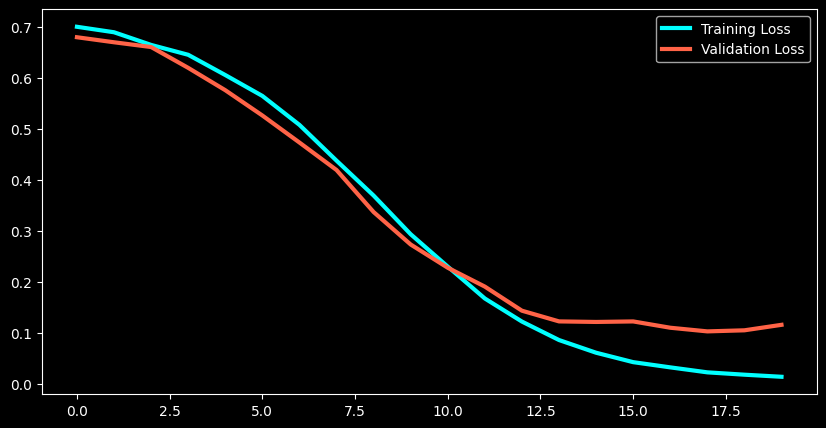

In [155]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

epochs = 20
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anime_classifier.parameters(), lr=lr)

train_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    train_loss = val_loss = 0
    
    anime_classifier.train()
    for X_batch, y_batch in train_loader:
        yhat = anime_classifier.forward(X_batch)
        loss = criterion(yhat, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    anime_classifier.eval()
    for X_batch, y_batch in val_loader:
        y_pred = anime_classifier.predict(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}/{epochs}: {train_loss = :.4f}, {val_loss = :.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, color="cyan", linewidth=3, label="Training Loss")
plt.plot(val_losses, color="tomato", linewidth=3, label="Validation Loss")
plt.legend()

In [156]:
accuracy = Accuracy(task="multiclass", num_classes=len(full_dataset.classes))

train_x, train_y = next(iter(DataLoader(train_dataset, len(train_dataset))))
val_x, val_y = next(iter(DataLoader(val_dataset, len(val_dataset))))

y_train_pred = anime_classifier.predict(train_x)
y_val_pred = anime_classifier.predict(val_x)

train_accuracy = accuracy(y_train_pred, train_y)
val_accuracy = accuracy(y_val_pred, val_y)

print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Validation Accuracy: {val_accuracy:.2%}")

Training Accuracy: 100.00%
Validation Accuracy: 96.67%


In [157]:
from sklearn.metrics import classification_report, confusion_matrix

def get_all_preds(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)


In [158]:
y_pred, y_true = get_all_preds(anime_classifier, val_loader, device)


In [159]:
print(classification_report(
    y_true,
    y_pred,
    target_names=full_dataset.classes
))

              precision    recall  f1-score   support

   anastasia       1.00      0.94      0.97        16
       takao       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



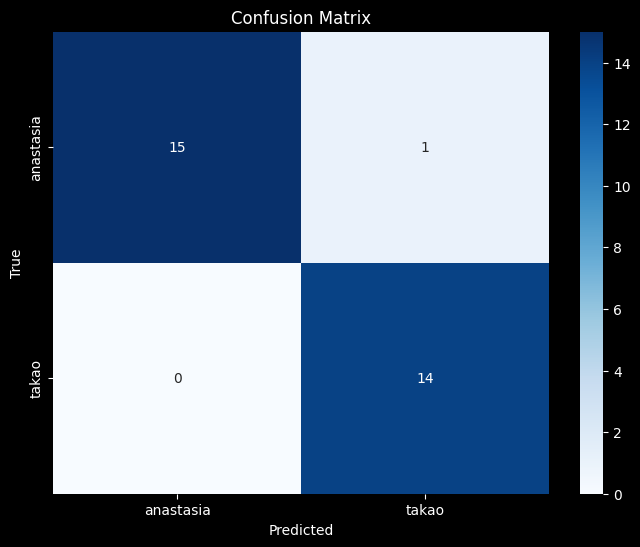

In [162]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d",
            cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
